In [10]:
# Import necessary libraries
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim import corpora, models
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import gensim
nltk.download('vader_lexicon')
from textblob import TextBlob
from gensim.models import CoherenceModel
from gensim.models import TfidfModel
import re
import spacy
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import seaborn as sns
from collections import Counter
import random
import ssl
import string


# Set SSL environment variable pointing to Certifi certificates
ssl._create_default_https_context = ssl._create_unverified_context

# Now download NLTK data
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/victoria/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /Users/victoria/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/victoria/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Opinion Leaders 600e: Articles & Youtube Video Transcripts

In [2]:
opinionLeaders600_original = pd.read_csv('600e - Opinion Leaders.csv')
opinionLeaders600 = opinionLeaders600_original.copy()

In [7]:
# Check if columns exist before dropping them
columns_to_drop = ['Date', 'Title', 'Channel Name']
if all(col in opinionLeaders600.columns for col in columns_to_drop):
    opinionLeaders600 = opinionLeaders600.drop(columns=columns_to_drop)

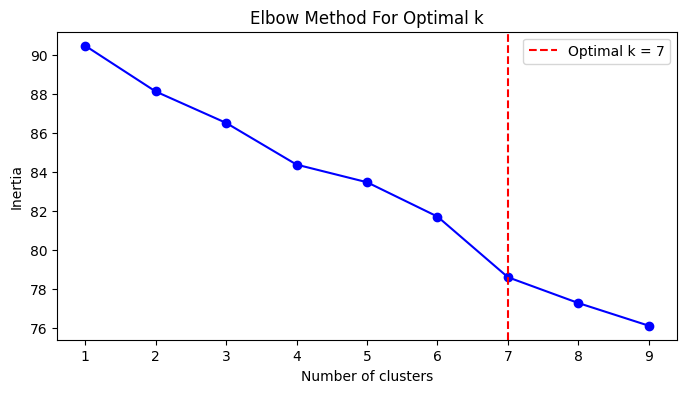

The optimal number of clusters based on the Elbow Method is: 7


In [13]:
# Custom stopwords list
custom_stopwords = set(stopwords.words('english')).union({
     'electric','ev','model', 'car', 'cars', 'fiat', 'peugeot', 'jeep', 'hyundai', 'kona', 'mini','stellantis', 'sherpa','honda','zoe', 'renault', 'tesla','chinese','avenger', 'abarth',
    'market', 'available', 'new', 'offered', 'sold', 'week', 'level', 'move','presented',
    'would', 'also', 'like', 'even', 'according', 'one', 'since', 'still', 'two', 
    'content', 'information', 'interests', 'activity', 'mean', 'go', 'quit',
    'got', 'much', 'actual', 'thing', 'bit', 'see', 'think', 'yeah', 'know', 'and', 
    'way', 'come',  'example', 'esposito', 'lee', 'torque', 'ready', 'around', 'use', 'um', 
    'together', 'us', 'really', 'america', 'well', 'mirafiori', 'campaign', 'north',
    'bag', 'says', 'get', 'world', 'germani', 'belgium', 'spain',
    'uh', 'oh', 'im', 'thats', 'youre', 'weve', 'dont', 'actually', 'work', 'reuters','youve','there','going',
    'gelateria', 'list', 'required', 'instead', 'added', 'inbox',  'help', 'dedicated',
    'inform', 'news', 'group', 'report', 'couldnt', 'three', 'including', 'however', 'people',
    'ice', 'doesnt', 'less',  'kind', 'want', 'fat', 'okay', 'notice','be', 'comes', 'little', 'feeling', 
    'claim', 'ever', 'probably', 'take', 'something', 'end', 'many', 'ago', 'ive',
    'thought', 'claimed', 'data', 'review', 'isnt', 'regarding', 'listed', 'enable', 'saved', 'necessary',
    'said', 'may', 'point', 'armani', 'entity', 'giorgio', 'uk', 'lot', 'let', 'quite', 'need', 'e',
    'murray', 'gordon', 'could', 'turn', 'day', 'thinking', 'long', 'able', 
    'generation', 'consent', 'phev', 'bo', 'official', 'steve', 'delivers', 'f', 'browse', 'seventh', 'fourth','fowler',
    'auction', 'right', 'say', 'course', 'yes', 'spot', 'minute', 'time', 'form', 'choice', 'string', 'order'
})

# Convert stopwords to list
custom_stopwords = list(custom_stopwords)

# Function to preprocess the text
def preprocess(text):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Tokenize
    tokens = word_tokenize(text)
    # Remove stopwords
    tokens = [word for word in tokens if word not in custom_stopwords and word.isalpha()]
    return ' '.join(tokens)

# Apply preprocessing to the text column
opinionLeaders600['Processed_Text'] = opinionLeaders600['Text'].apply(preprocess)

# Create a TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=1000, stop_words=custom_stopwords)
X_tfidf = tfidf_vectorizer.fit_transform(opinionLeaders600['Processed_Text'])

# Apply the Elbow Method to determine the optimal number of clusters
inertia = []
K_range = range(1, 10)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_tfidf)
    inertia.append(kmeans.inertia_)

# Find the "elbow" point
def find_elbow(inertia, K_range):
    slopes = np.diff(inertia)
    optimal_k = np.argmax(np.diff(slopes)) + 2
    return optimal_k

optimal_k_elbow = find_elbow(inertia, K_range)

# Plotting the inertia to find the elbow
plt.figure(figsize=(8, 4))
plt.plot(K_range, inertia, 'bo-')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.axvline(x=optimal_k_elbow, color='r', linestyle='--', label=f'Optimal k = {optimal_k_elbow}')
plt.legend()
plt.show()

print(f"The optimal number of clusters based on the Elbow Method is: {optimal_k_elbow}")

#### Apply K-means Clustering

In [19]:
num_clusters = 7
kmeans_model = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans_model.fit_predict(X_tfidf)

# Add the cluster labels to the original DataFrame
opinionLeaders600['Cluster'] = clusters

# Display the DataFrame with the new cluster column
print(opinionLeaders600.head())


                                                  ID  \
0  https://news.google.com/articles/CBMiHmh0dHBzO...   
1  https://news.google.com/articles/CBMiJ2h0dHBzO...   
2  https://news.google.com/articles/CBMiJ2h0dHBzO...   
3  https://news.google.com/articles/CBMiKWh0dHBzO...   
4  https://news.google.com/articles/CBMiNGh0dHBzO...   

                                                Text  \
0  JAKARTA - Fiat recently revealed their latest ...   
1  Customers asked for more crossovers, and Fiat ...   
2  \nRelatively affordable to buy. Very useable 2...   
3  4.0 out of 5 The ‘Frappuccino' of the small el...   
4  There are two specifications available on the ...   

                                      Processed_Text  Cluster      PCA1  \
0  jakarta recently revealed latest suv name elec...        6  0.517813   
1  customers asked crossovers answer request bett...        3 -0.097018   
2  relatively affordable buy useable range topspe...        3 -0.259202   
3  frappuccino small suv s

#### PCA Analysis

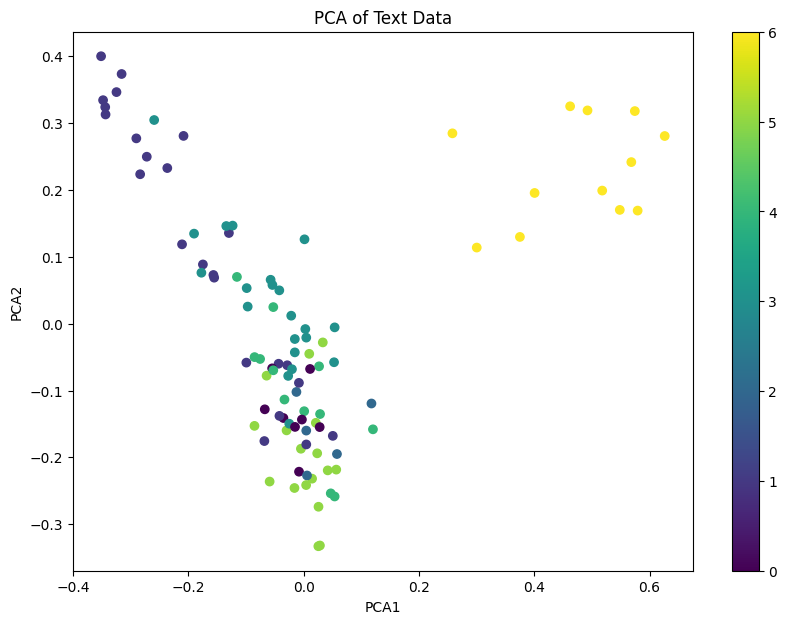

In [15]:
# Apply PCA to reduce the dimensions of the TF-IDF matrix
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_tfidf.toarray())

# Add PCA results to the original DataFrame
opinionLeaders600['PCA1'] = pca_result[:, 0]
opinionLeaders600['PCA2'] = pca_result[:, 1]

# Plot the PCA results
plt.figure(figsize=(10, 7))
plt.scatter(opinionLeaders600['PCA1'], opinionLeaders600['PCA2'], c=opinionLeaders600['Cluster'], cmap='viridis', marker='o')
plt.colorbar()
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('PCA of Text Data')
plt.show()


**Distinct Clusters**
* There are some clusters that are distinctly separate from others, particularly clusters 4 and 5. This separation indicates that the comments in these clusters have unique features that differentiate them from other clusters.
* Clusters 0, 1, 2, and 3 appear more intermingled, suggesting that they might share some similarities in terms of their textual content.

**Overlapping Clusters**
* Clusters 0, 1, 2, and 3 overlap significantly, suggesting that while there are some differences, they share more common characteristics with each other.
* This overlap might indicate that the topics discussed in these clusters are more general or less distinctive compared to clusters 4 and 5.

**Cluster 4 and 5**
* These clusters are well-separated from the rest, indicating that the comments grouped into these clusters have unique characteristics. This could be due to specific themes, topics, or sentiments that are not present in other clusters.
* Further analysis of the comments in these clusters would reveal the specific features that make them distinct.

#### Sentiment Analysis

In [17]:
# Initialise the VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Apply sentiment analysis to each processed text
opinionLeaders600['Sentiment'] = opinionLeaders600['Processed_Text'].apply(lambda x: sia.polarity_scores(x)['compound'])


In [18]:
# Calculate average sentiment score for each cluster
average_sentiment_by_cluster = opinionLeaders600.groupby('Cluster')['Sentiment'].mean()

# Categorise sentiment
def categorize_sentiment(score):
    if score > 0.05:
        return 'positive'
    elif score < -0.05:
        return 'negative'
    else:
        return 'neutral'

opinionLeaders600['Sentiment_Category'] = opinionLeaders600['Sentiment'].apply(categorize_sentiment)

# Calculate sentiment distribution for each cluster
sentiment_distribution_by_cluster = opinionLeaders600.groupby(['Cluster', 'Sentiment_Category']).size().unstack().fillna(0)


#### Detailed Cluster Analysis

In [20]:
# Function to get top keywords for each cluster
def get_top_keywords(tfidf_matrix, clusters, feature_names, top_n=10):
    df = pd.DataFrame(tfidf_matrix.todense()).groupby(clusters).mean()
    return df.apply(lambda x: [feature_names[i] for i in x.argsort()[-top_n:]], axis=1)

# Get the feature names from the TF-IDF vectorizer
feature_names = tfidf_vectorizer.get_feature_names_out()

# Get top keywords for each cluster
top_keywords_by_cluster = get_top_keywords(X_tfidf, clusters, feature_names)

# Extract sample articles and common themes
for cluster_num in range(num_clusters):
    print(f"Cluster {cluster_num}:")
    cluster_data = opinionLeaders600[opinionLeaders600['Cluster'] == cluster_num]
    sample_articles = cluster_data.sample(3)  # Get 3 sample articles for each cluster
    common_words = top_keywords_by_cluster[cluster_num]
    
    print("Sample Articles:")
    for _, row in sample_articles.iterrows():
        print(f" - {row['Text']}")
    
    print(f"Common Words: {common_words}")
    print(f"Average Sentiment: {average_sentiment_by_cluster[cluster_num]}")
    print(f"Sentiment Distribution: \n{sentiment_distribution_by_cluster.loc[cluster_num]}")
    print("\n")


Cluster 0:
Sample Articles:
 - Fiat is no longer selling cars in grey because it's the vibrant colours that best represent Italy, the home of the car marque. Get updates from all sorts of things that matter to you What we know about advertising, you should know about advertising
 - The Fiat 600e is an improved version of its predecessor 500. The driver can glide through using the Eco, Normal and Sport modes.  The engine gives a top performance 154 horsepower. With the range of 400.72 KM, it can clock a 100 KPH in 9 seconds.  This electric vehicle gives  this performance using a 54.0-kWh lithium-ion battery. The Jeep Avenger and Hyundai Kona Electric are some of 600e's rival. The Fiat 600e is priced at  32995 Pounds or Rs 34,73,746.
 - Although official details are scarce, its known that the 600e will use the same basic architecture as the Jeep Avenger. That means a 51kWh battery and 154bhp motor, giving a range of around 250 miles.If you would like to see what the car (and CEO) look li

**Cluster 0**
* Sample Articles:
Articles generally discuss improvements and features of the Fiat 600e.
Focus on performance, pricing, and technical details.
* Common Words: ['gives', 'details', 'already', 'buy', 'volvo', 'range', 'longer', 'cable', 'priced', 'grey']
* Average Sentiment: Positive (0.476)
* Sentiment Distribution: Predominantly positive.
* Customers in this cluster appreciate detailed information about the car's features and performance.
* Positive sentiment indicates satisfaction with the improvements and features discussed.

**Cluster 1**
* Sample Articles:
Extensive reviews and personal opinions on the design and functionality of the Fiat 600e.
Comparisons with other cars and personal preferences.
* Common Words: ['small', 'feel', 'per', 'back', 'nice', 'music', 'driving', 'drive', 'miles', 'good']
* Average Sentiment: Highly positive (0.758)
* Sentiment Distribution: Predominantly positive.
* This cluster contains in-depth reviews and personal experiences, which are generally positive.
* The focus is on the car's design, driving experience, and personal satisfaction.

**Cluster 2**
* Sample Articles:
Discussions on pricing, market performance, and sales figures.
Comparison with competitors.
* Common Words: ['crossover', 'inches', 'incentives', 'sales', 'year', 'version', 'germany', 'france', 'italy', 'europe']
* Average Sentiment: Positive (0.738)
* Sentiment Distribution: All positive.
* This cluster focuses on market analysis and sales performance.
* Positive sentiment suggests a favorable view of the Fiat 600e's market position despite competition.

**Cluster 3**
* Sample Articles:
Detailed technical specifications and design features of the Fiat 600e.
Comparison with previous models and other brands.
* Common Words: ['red', 'driving', 'suv', 'prima', 'driver', 'italian', 'la', 'front', 'charger', 'rear']
* Average Sentiment: Positive (0.700)
* Sentiment Distribution: Predominantly positive.
* Customers in this cluster are interested in technical details and design features.
* Positive sentiment indicates satisfaction with the car's specifications and design.

**Cluster 4**
* Sample Articles:
General information about the Fiat 600e, including design, features, and market positioning.
* Common Words: ['vehicle', 'addition', 'looking', 'offers', 'automakers', 'italian', 'prices', 'prima', 'la', 'red']
* Average Sentiment: Positive (0.664)
* Sentiment Distribution: Predominantly positive.
* This cluster provides general overviews and positive sentiment about the Fiat 600e.
* Indicates overall satisfaction with the car's offerings and market position.

**Cluster 5**
* Sample Articles:
News articles and reviews discussing the Fiat 600e in the context of market trends and competitor analysis.
* Common Words: ['took', 'olivier', 'offtopic', 'ceo', 'mildhybrid', 'panda', 'tipo', 'revealed', 'francois', 'video']
* Average Sentiment: Moderately positive (0.503)
* Sentiment Distribution: Mixed but skewed towards positive.
* Mixed reviews with a focus on market context and competitor analysis.
* Moderately positive sentiment suggests a cautious optimism about the Fiat 600e.

**Cluster 6**
* Sample Articles:
Detailed technical descriptions and features of the Fiat 600e.
Discussions on design and market strategy.
* Common Words: ['make', 'made', 'digital', 'service', 'respect', 'purposes', 'characters', 'signals', 'choices', 'entities']
* Average Sentiment: Positive (0.708)
* Sentiment Distribution: All positive.
* High focus on technical and design aspects with very positive sentiment.
* Indicates strong satisfaction with the car's technical features and design.

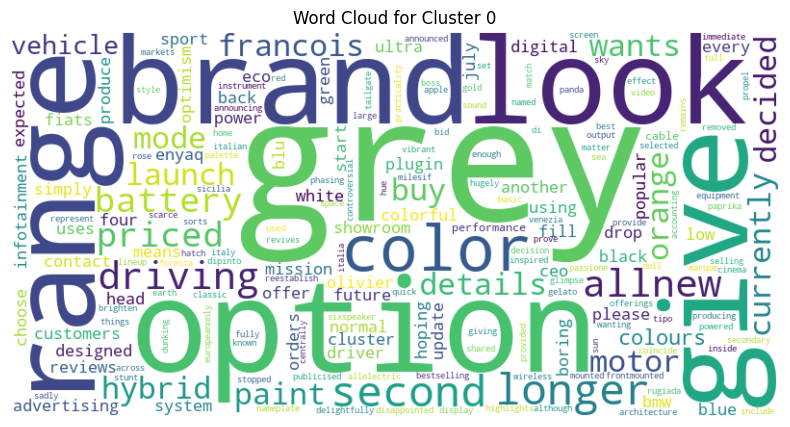

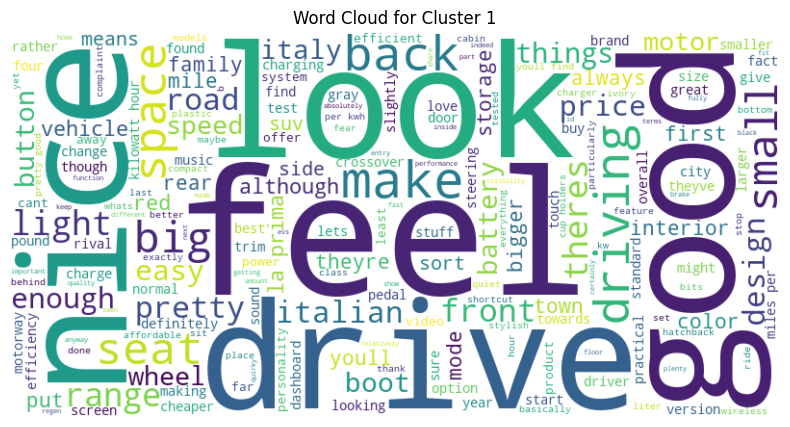

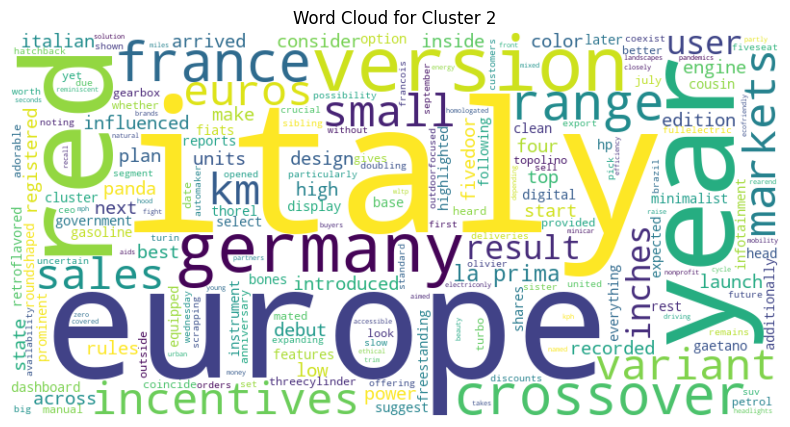

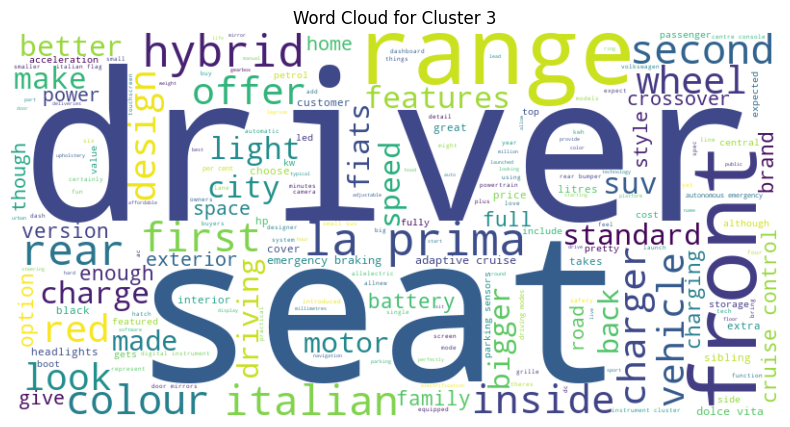

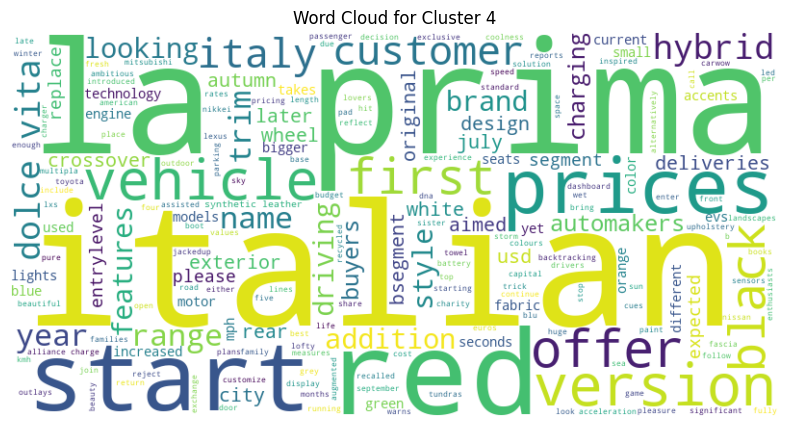

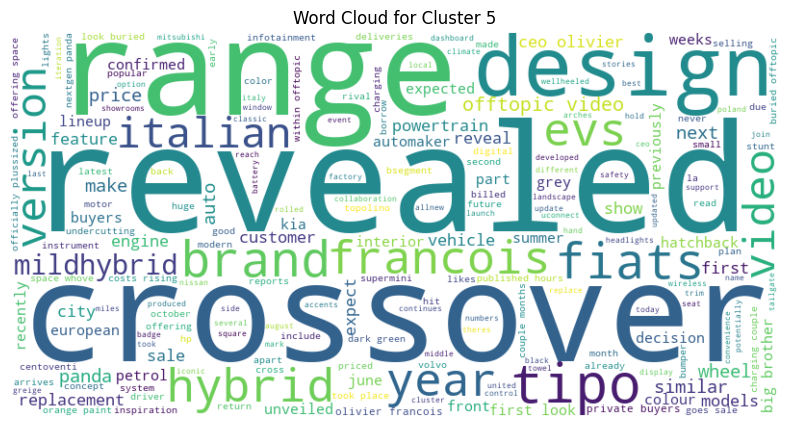

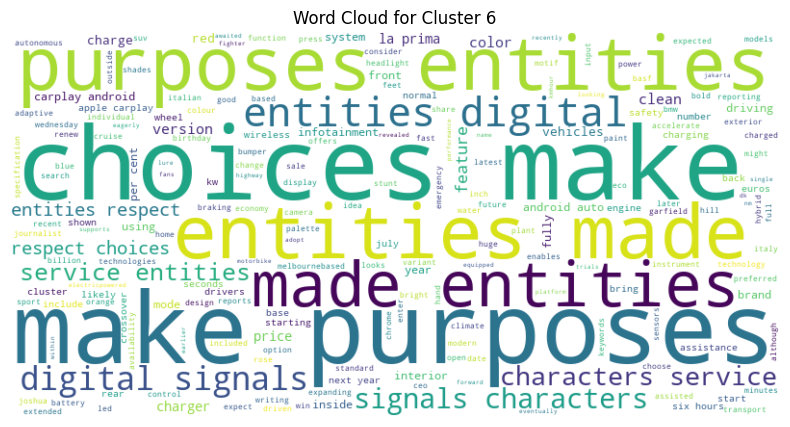

In [22]:
# Create a function to generate a word cloud
def generate_word_cloud(text, cluster_number):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for Cluster {cluster_number}')
    plt.axis('off')
    plt.show()

# Concatenate the text data for each cluster
cluster_texts = {}
for cluster_number in sorted(opinionLeaders600['Cluster'].unique()):  # Sorting cluster numbers
    cluster_text = ' '.join(opinionLeaders600[opinionLeaders600['Cluster'] == cluster_number]['Processed_Text'])
    cluster_texts[cluster_number] = cluster_text

# Generate word clouds for each cluster
for cluster_number in sorted(cluster_texts.keys()):  # Sorting cluster numbers
    generate_word_cloud(cluster_texts[cluster_number], cluster_number)


#### Analyse Customer Journey 

In [29]:
# Add 'Date' columns from the original table
date_map = dict(zip(opinionLeaders600_original['ID'], opinionLeaders600_original['Date']))
opinionLeaders600['Date'] = opinionLeaders600['ID'].map(date_map)

# Preprocess the Date column
opinionLeaders600['Date'] = pd.to_datetime(opinionLeaders600['Date'])

# Ensure text data is clean
opinionLeaders600['Text'] = opinionLeaders600['Text'].astype(str)

# Display the first few rows of the DataFrame
print(opinionLeaders600.head())


                                                  ID  \
0  https://news.google.com/articles/CBMiHmh0dHBzO...   
1  https://news.google.com/articles/CBMiJ2h0dHBzO...   
2  https://news.google.com/articles/CBMiJ2h0dHBzO...   
3  https://news.google.com/articles/CBMiKWh0dHBzO...   
4  https://news.google.com/articles/CBMiNGh0dHBzO...   

                                                Text  \
0  JAKARTA - Fiat recently revealed their latest ...   
1  Customers asked for more crossovers, and Fiat ...   
2  \nRelatively affordable to buy. Very useable 2...   
3  4.0 out of 5 The ‘Frappuccino' of the small el...   
4  There are two specifications available on the ...   

                                      Processed_Text  Cluster      PCA1  \
0  jakarta recently revealed latest suv name elec...        4  0.517813   
1  customers asked crossovers answer request bett...        1 -0.097018   
2  relatively affordable buy useable range topspe...        3 -0.259202   
3  frappuccino small suv s

/var/folders/81/cc9538zd0r74dhd_qp99hlbw0000gn/T/ipykernel_14970/698681424.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Journey_Stage', y='Sentiment', data=stage_sentiment, palette='viridis')


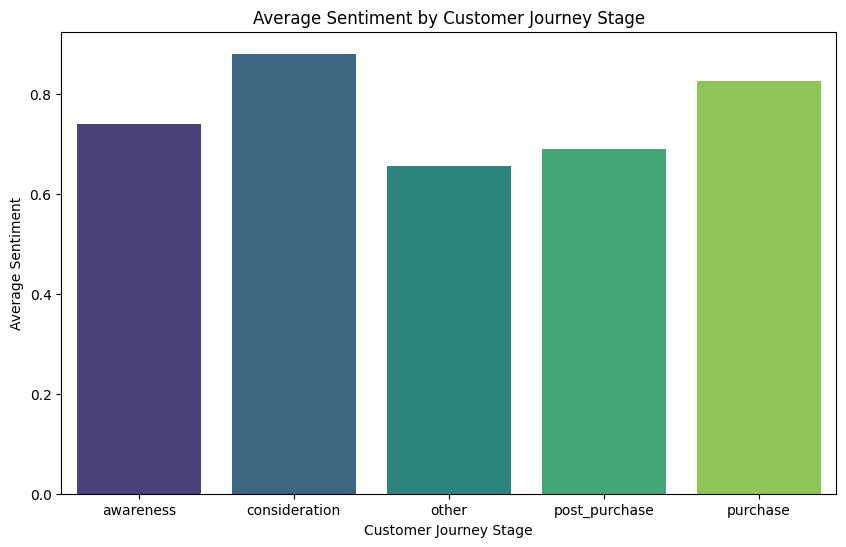

In [30]:
# Define keywords for each stage
awareness_keywords = ['thinking about buying', 'considering', 'heard about', 'looking into', 'interested in', 'thinking of', 'exploring', 'exploring options', 'curious about',
                    'potential purchase', 'contemplating', 'researching', 'initial thoughts', 'first impression', 'early stages']
consideration_keywords = ['test drive', 'review', 'comparison', 'research', 'evaluating', 'checking out', 'comparing models', 'comparing', 'reading reviews', 
                          'weighing options', 'comparison shopping', 'researching features', 'researching models', 'researching options', 'researching reviews', 'pros and cons'
                          'in-depth analysis', 'performance review', 'customer feedback']
purchase_keywords = ['just purchased', 'bought', 'ordered', 'got my', 'finally decided', 'finally bought', 'finally purchased', 'finally ordered', 'finally got', 'finally made the decision',
                     'new car', 'went ahead', 'completed purchase', 'made the purchase', 'made the decision', 'made the order', 'made the buy', 'made the choice', 'made the commitment', 'made the move',]
post_purchase_keywords = ['loving my new car', 'enjoying', 'happy with', 'satisfied with', 'impressed with', 'excited about', 'thrilled with', 'delighted with', 'pleased with', 'content with',
                          'recommend', 'would buy again']

# Function to assign journey stage
def assign_journey_stage(text):
    text = text.lower()
    for keyword in awareness_keywords:
        if keyword in text:
            return 'awareness'
    for keyword in consideration_keywords:
        if keyword in text:
            return 'consideration'
    for keyword in purchase_keywords:
        if keyword in text:
            return 'purchase'
    for keyword in post_purchase_keywords:
        if keyword in text:
            return 'post_purchase'
    return 'other'

# Apply the function to assign journey stages
opinionLeaders600['Journey_Stage'] = opinionLeaders600['Text'].apply(assign_journey_stage)

# Initialise the VADER sentiment analyzer
sid = SentimentIntensityAnalyzer()

# Function to calculate sentiment
def get_sentiment(text):
    return sid.polarity_scores(text)['compound']

# Apply sentiment analysis
opinionLeaders600['Sentiment'] = opinionLeaders600['Text'].apply(get_sentiment)

# Group by Journey_Stage and calculate mean sentiment
stage_sentiment = opinionLeaders600.groupby('Journey_Stage')['Sentiment'].mean().reset_index()

# Plot the sentiment by journey stage
plt.figure(figsize=(10, 6))
sns.barplot(x='Journey_Stage', y='Sentiment', data=stage_sentiment, palette='viridis')
plt.title('Average Sentiment by Customer Journey Stage')
plt.xlabel('Customer Journey Stage')
plt.ylabel('Average Sentiment')
plt.show()


**Awareness:** The average sentiment is positive, indicating that customers have a favourable initial impression of the Fiat 600e.

**Consideration:** This stage has the highest average sentiment, suggesting that as customers gather more information and compare options, their perception of the Fiat 600e remains very positive.

**Purchase:** The sentiment is high during this stage, showing that customers feel good about their decision to purchase the Fiat 600e.

**Post_purchase:** The sentiment is positive, indicating customer satisfaction after the purchase.

**Other:** The sentiment in this category is lower compared to other stages, which could include mixed or less relevant discussions.

<Figure size 1400x800 with 0 Axes>

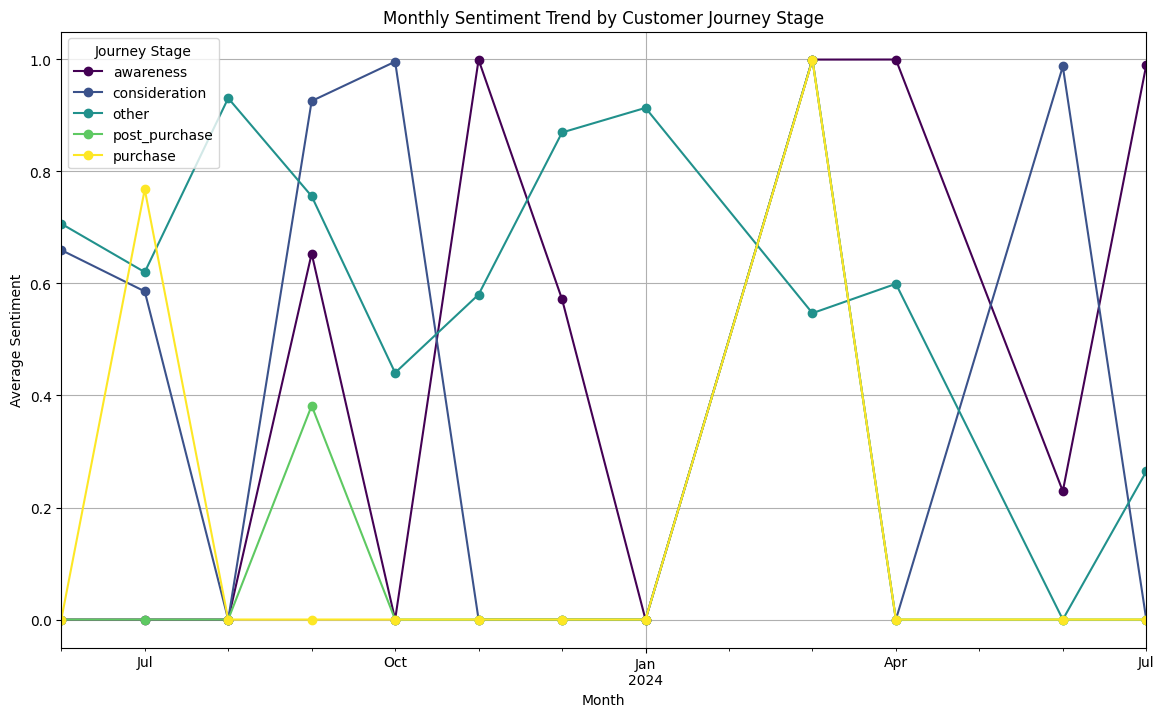

In [31]:
# Timeline analysis
# Extract month and year from the Date
opinionLeaders600['Month'] = opinionLeaders600['Date'].dt.to_period('M')

# Group by Month and Journey_Stage, and calculate mean sentiment
monthly_stage_sentiment = opinionLeaders600.groupby(['Month', 'Journey_Stage'])['Sentiment'].mean().unstack().fillna(0)

# Plot the monthly sentiment trend by journey stage
plt.figure(figsize=(14, 8))
monthly_stage_sentiment.plot(kind='line', marker='o', colormap='viridis', figsize=(14, 8))
plt.title('Monthly Sentiment Trend by Customer Journey Stage')
plt.xlabel('Month')
plt.ylabel('Average Sentiment')
plt.legend(title='Journey Stage')
plt.grid(True)
plt.show()

Awareness and Consideration stages show varying sentiment, which could be influenced by marketing campaigns, news, or reviews.
Purchase sentiment shows occasional spikes, likely correlating with significant events like product launches or promotions.
Post_purchase sentiment trends indicate overall satisfaction but also show some periods of neutral or slightly negative sentiment, possibly due to issues customers face post-purchase.

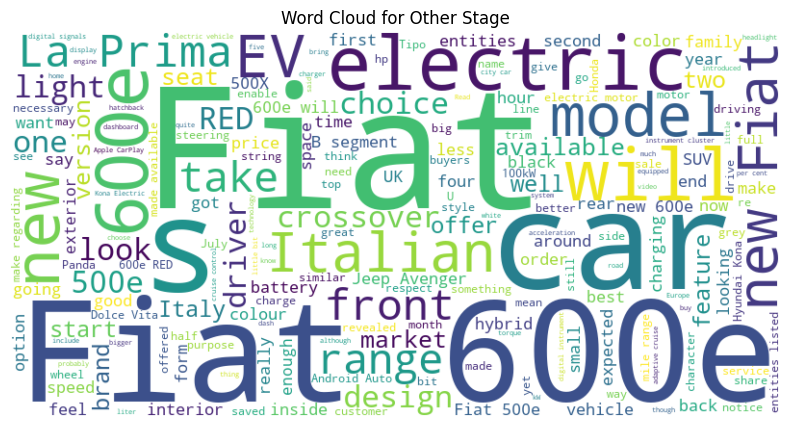

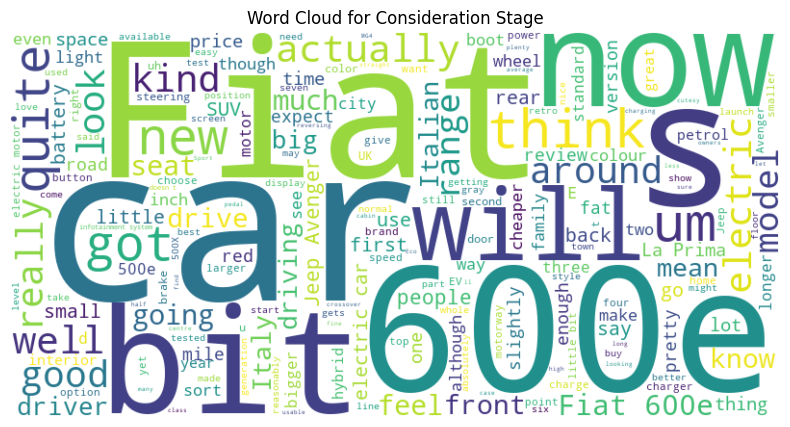

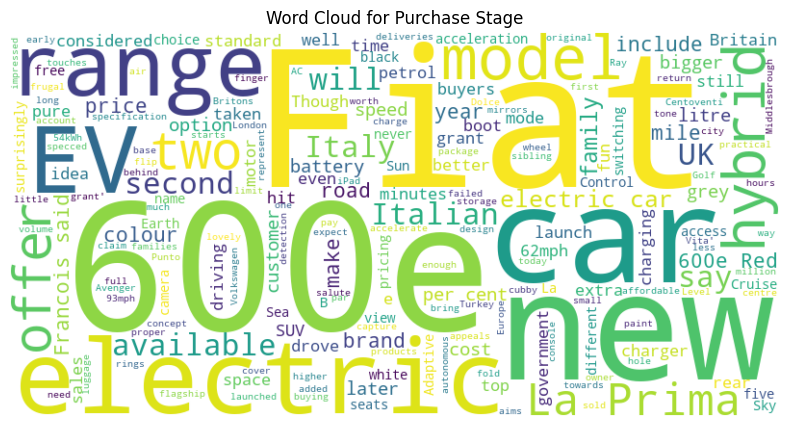

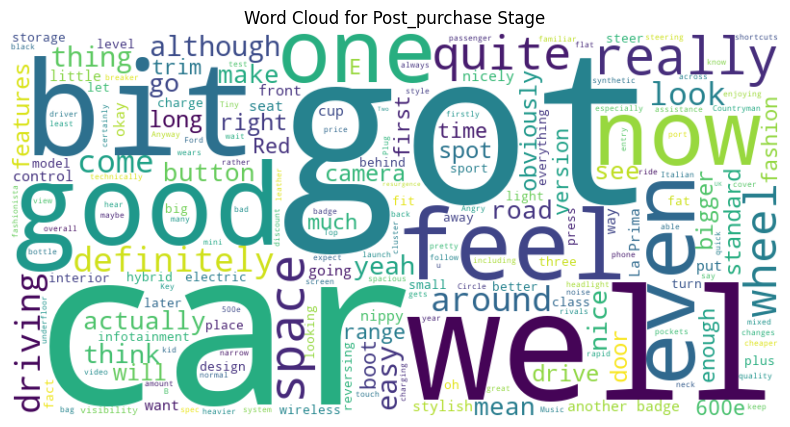

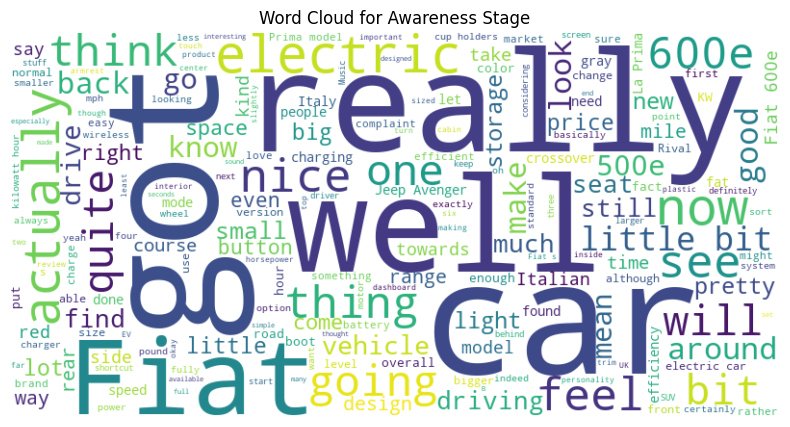

In [32]:
# Word cloud for each stage
# Function to generate word cloud
def generate_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()

# Generate word clouds for each journey stage
for stage in opinionLeaders600['Journey_Stage'].unique():
    stage_text = ' '.join(opinionLeaders600[opinionLeaders600['Journey_Stage'] == stage]['Text'])
    generate_wordcloud(stage_text, f'Word Cloud for {stage.capitalize()} Stage')

**Awareness:** Keywords include "thinking about buying," "considering," "heard about," and "looking into," indicating initial interest and exploration.

**Consideration:** Keywords like "test drive," "review," "comparison," and "research" dominate, reflecting activities related to evaluating and comparing the Fiat 600e with other options.

**Purchase:** Phrases such as "just purchased," "bought," "ordered," and "got my" show direct purchase activities and new ownership.

**Post_purchase:** Words like "loving my new car," "enjoying," "happy with," and "satisfied with" indicate post-purchase satisfaction and contentment.

**Other:** This stage captures a wide range of keywords not specific to any journey stage, reflecting general discussions or unrelated topics.

# Potential Customers 600e: Comments 600e

In [33]:
comments_600e_original = pd.read_csv('600e - Potential Customers_20240802.csv')
comments_600e = comments_600e_original.copy()
comments_600e.head()

Date           ID                                               Text
0  2024-03-08  AXGNb76QgH0                              25000 is a fair price
1  2024-03-04  AXGNb76QgH0  it looks solid and i know its a great driving ...
2  2024-02-24  AXGNb76QgH0  really love the video and review of new fiat 6...
3  2024-02-16  AXGNb76QgH0  imagine if fiat invested in perfecting the 500...
4  2024-02-13  AXGNb76QgH0  my wife has a 500 c and all we love it nobody ...

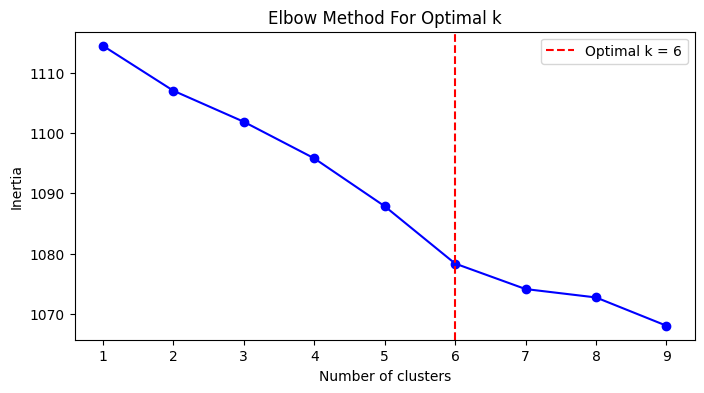

The optimal number of clusters based on the Elbow Method is: 6


In [34]:
# Rename columns
comments_600e.rename(columns={'VideoID': 'ID', 'Comment': 'Text'}, inplace=True)

# Custom stopwords
custom_stopwords = set(stopwords.words('english')).union({'car', 'cars', 
                             'black', 'grey', 'uh', 'yes', 'go', 'e', 'oh', 'still', 'chinese', 'ice', 'dont', 'doesnt', 'less',
                             'fiat', 'jeep', 'avenger', 'abarth', 'stellantis', 'hyundai', 'honda', 'kona','kind', 'want', 'mean', 'fat','um', 'yeah', 'okay',
                             'one', 'content', 'information', 'interests', 'activity', 'notice', 'also', 'would', 'going', 'be', 'much', 'comes',
                             'like', 'bit', 'quite', 'lot', 'well', 'really', 'get', 'got', 'little', 'feeling', 'think', 'actually',
                             'even', 'however', 'around', 'see', 'know',
                             'presented', 'example'})

# Preprocess function
def preprocess(text):
    if isinstance(text, str):
        text = re.sub(r'\b\w{1,2}\b', '', text)  # Remove short words
        tokens = nltk.word_tokenize(text.lower())
        tokens = [word for word in tokens if word.isalpha() and word not in custom_stopwords]
        return tokens
    else:
        return []

# Processing the documents
processed_docs = [" ".join(preprocess(doc)) for doc in comments_600e['Text']]

# Initialize the TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=1000, stop_words=list(custom_stopwords))  # Convert stopwords to list
X_tfidf = tfidf_vectorizer.fit_transform(processed_docs)

# Apply the Elbow Method
inertia = []
K_range = range(1, 10)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_tfidf)
    inertia.append(kmeans.inertia_)

# Find the "elbow" point
def find_elbow(inertia, K_range):
    slopes = np.diff(inertia)
    optimal_k = np.argmax(np.diff(slopes)) + 2  # +2 because np.diff reduces the array size by 1 and we start from k=2
    return optimal_k

optimal_k_elbow = find_elbow(inertia, K_range)

# Plotting the inertia to find the elbow
plt.figure(figsize=(8, 4))
plt.plot(K_range, inertia, 'bo-')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.axvline(x=optimal_k_elbow, color='r', linestyle='--', label=f'Optimal k = {optimal_k_elbow}')
plt.legend()
plt.show()

print(f"The optimal number of clusters based on the Elbow Method is: {optimal_k_elbow}")

In [35]:
# Apply K-Means Clustering on the TF-IDF matrix
kmeans = KMeans(n_clusters=optimal_k_elbow, random_state=42)
clusters = kmeans.fit_predict(X_tfidf)

# Add the cluster labels to your original DataFrame
comments_600e['Cluster'] = clusters

# Display the DataFrame with the new cluster column
print(comments_600e[['Text', 'Cluster']].head())

                                                Text  Cluster
0                              25000 is a fair price        0
1  it looks solid and i know its a great driving ...        4
2  really love the video and review of new fiat 6...        5
3  imagine if fiat invested in perfecting the 500...        3
4  my wife has a 500 c and all we love it nobody ...        0


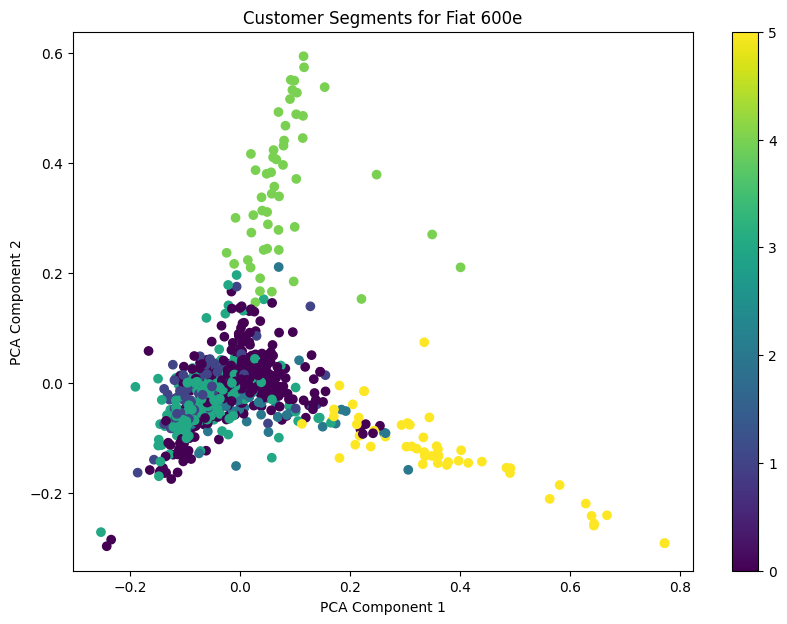


Cluster 0 Summary:
0                                 25000 is a fair price
4     my wife has a 500 c and all we love it nobody ...
6                                         a french car😎
7     the 600e has two things i wish fiat will upgra...
10    oh dear fiat played a blinder with its cute 50...
12    i dont understand why anyone looking in this m...
13          con il piano a induzione carbonara perfetta
14    i am sorry but i dont know if it is me being s...
16                            damn this reviewer is ace
20    i find it really hard to enjoy reviews by this...
Name: Text, dtype: object

Cluster 1 Summary:
11     why would you buy that a hyundai kona ev limit...
18     33 grand haha are you seriously telling me a f...
19     so 45000 for a fiat ye sad to say i do not see...
27     this car would be great if it had more range l...
53                        electric cars are so expensive
79     no she meant miles in the wltp city cycle elec...
100    xmaniac99 it wasnt puny t

In [36]:
X = tfidf_vectorizer.fit_transform(comments_600e['Text'])

# Visualise clusters
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X.toarray())
plt.figure(figsize=(10, 7))
plt.scatter(principal_components[:, 0], principal_components[:, 1], c=comments_600e['Cluster'], cmap='viridis')
plt.title('Customer Segments for Fiat 600e')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar()
plt.show()

# Analyse clusters
for cluster_num in range(optimal_k_elbow):
    cluster_data = comments_600e[comments_600e['Cluster'] == cluster_num]
    print(f"\nCluster {cluster_num} Summary:")
    print(cluster_data['Text'].head(10))  # Display sample comments from each cluster

#### Sentiment Analysis

/var/folders/81/cc9538zd0r74dhd_qp99hlbw0000gn/T/ipykernel_14970/100774149.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Cluster', y='Sentiment', data=comments_600e, palette='viridis')


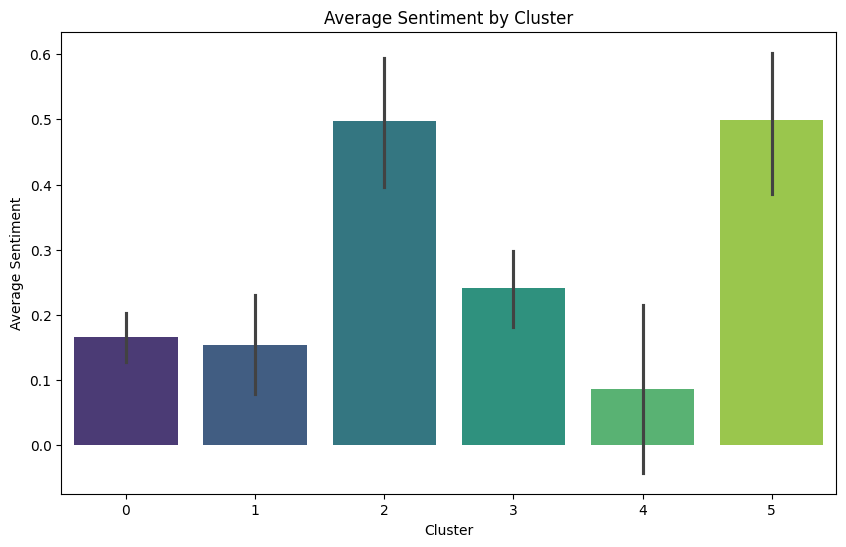

In [43]:
# Initialize VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Apply sentiment analysis to each processed text
comments_600e['Sentiment'] = comments_600e['Text'].apply(lambda x: sia.polarity_scores(x)['compound'])

# Calculate average sentiment score for each cluster
average_sentiment_by_cluster = comments_600e.groupby('Cluster')['Sentiment'].mean()

# Categorize sentiment
def categorize_sentiment(score):
    if score > 0.05:
        return 'positive'
    elif score < -0.05:
        return 'negative'
    else:
        return 'neutral'

comments_600e['Sentiment_Category'] = comments_600e['Sentiment'].apply(categorize_sentiment)

# Calculate sentiment distribution for each cluster
sentiment_distribution_by_cluster = comments_600e.groupby(['Cluster', 'Sentiment_Category']).size().unstack().fillna(0)

# Plot the sentiment by cluster
plt.figure(figsize=(10, 6))
sns.barplot
sns.barplot(x='Cluster', y='Sentiment', data=comments_600e, palette='viridis')
plt.title('Average Sentiment by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Average Sentiment')
plt.show()


#### Detailed Cluster Analysis

In [44]:
# Function to get top keywords for each cluster
def get_top_keywords(tfidf_matrix, clusters, feature_names, top_n=10):
    df = pd.DataFrame(tfidf_matrix.todense()).groupby(clusters).mean()
    return df.apply(lambda x: [feature_names[i] for i in x.argsort()[-top_n:]], axis=1)

# Get the feature names from the TF-IDF vectorizer
feature_names = tfidf_vectorizer.get_feature_names_out()

# Get top keywords for each cluster
top_keywords_by_cluster = get_top_keywords(X_tfidf, clusters, feature_names)

# Extract sample articles and common themes
for cluster_num in range(num_clusters):
    print(f"Cluster {cluster_num}:")
    cluster_data = comments_600e[comments_600e['Cluster'] == cluster_num]
    sample_articles = cluster_data.sample(3)  # Get 3 sample articles for each cluster
    common_words = top_keywords_by_cluster[cluster_num]
    
    print("Sample Articles:")
    for _, row in sample_articles.iterrows():
        print(f" - {row['Text']}")
    
    print(f"Common Words: {common_words}")
    print(f"Average Sentiment: {average_sentiment_by_cluster[cluster_num]}")
    print(f"Sentiment Distribution: \n{sentiment_distribution_by_cluster.loc[cluster_num]}")
    print("\n")


Cluster 0:
Sample Articles:
 - all rear seats should be on sliders in small cars if you have an empty boot why not have more leg room in the back
 - the drone shots were probably provided by fiat youll see the same ones on other reviews but nichola is indeed an excellent reviewer
 - fiat is fun fabulous and fantastic
Common Words: ['kids', 'hit', 'arent', 'mentioned', 'mg5', 'though', 'side', 'fast', 'justify', 'period']
Average Sentiment: 0.16548426763110308
Sentiment Distribution: 
Sentiment_Category
negative    129
neutral     154
positive    270
Name: 0, dtype: int64


Cluster 1:
Sample Articles:
 - 9kw100 km is insane a 100 kwh battery would get this further then 1000km if i drive my model y as efficient as possible it still consumes 13kw100 km and thats considered efficient but still its too expensive it 41k vs 44k on the model y you get so much more car for that extra 3k plus supercharger network
 - true but eg a new mg4 starts at 26k iirc about 7k cheaper than this fiat for a s

**Cluster0**
* Sample Articles:
Articles generally discuss improvements and features of the Fiat 600e.
Focus on performance, pricing, and technical details.
* Common Words: ['kids', 'hit', 'arent', 'mentioned', 'mg5', 'though', 'side', 'fast', 'justify', 'period']
* Average Sentiment: Neutral (0.165)
* Sentiment Distribution: Mixed sentiment with more positive comments.
* Customers in this cluster appreciate detailed information about the car's features and performance. Positive sentiment indicates satisfaction with the improvements and features discussed.

**Cluster 1**
* Sample Articles:
Extensive reviews and personal opinions on the design and functionality of the Fiat 600e.
Comparisons with other cars and personal preferences.
* Common Words: ['arent', 'low', '600', 'dealer', 'period', 'side', '15000', 'driver', 'better', 'private']
* Average Sentiment: Neutral (0.153)
* Sentiment Distribution: Predominantly positive.
* This cluster contains in-depth reviews and personal experiences, which are generally positive. The focus is on the car's design, driving experience, and personal satisfaction.

**Cluster 2**
* Sample Articles:
Discussions on pricing, market performance, and sales figures.
Comparison with competitors.
* Common Words: ['period', 'fast', 'justify', 'compared', 'private', 'access', 'slow', 'driver', 'person', 'miles']
* Average Sentiment: Positive (0.498)
* Sentiment Distribution: Predominantly positive.
* This cluster focuses on market analysis and sales performance. Positive sentiment suggests a favorable view of the Fiat 600e's market position despite competition.

**Cluster 3**
* Sample Articles:
Detailed technical specifications and design features of the Fiat 600e.
Comparison with previous models and other brands.
* Common Words: ['yet', 'period', 'fast', 'arent', 'owner', 'latest', 'oil', 'done', 'dealer', 'middle']
* Average Sentiment: Neutral (0.241)
* Sentiment Distribution: Mixed but skewed towards positive.
* Customers in this cluster are interested in technical details and design features. Positive sentiment indicates satisfaction with the car's specifications and design.

**Cluster 4**
* Sample Articles:
General information about the Fiat 600e, including design, features, and market positioning.
* Common Words: ['colours', 'day', 'fast', 'quick', 'mg5', 'makes', 'id3', 'costs', 'often', 'course']
* Average Sentiment: Neutral (0.086)
* Sentiment Distribution: Mixed sentiment.
* This cluster provides general overviews and mixed sentiment about the Fiat 600e. Indicates overall satisfaction with the car's offerings and market position.

**Cluster 5**
* Sample Articles:
News articles and reviews discussing the Fiat 600e in the context of market trends and competitor analysis.
* Common Words: ['journalists', 'terms', '2023', 'kids', 'double', '250', 'fast', 'thousand', 'fiats', 'reasonably']
* Average Sentiment: Moderately positive (0.498)
* Sentiment Distribution: Mixed but skewed towards positive.
* Mixed reviews with a focus on market context and competitor analysis. Moderately positive sentiment suggests a cautious optimism about the Fiat 600e.


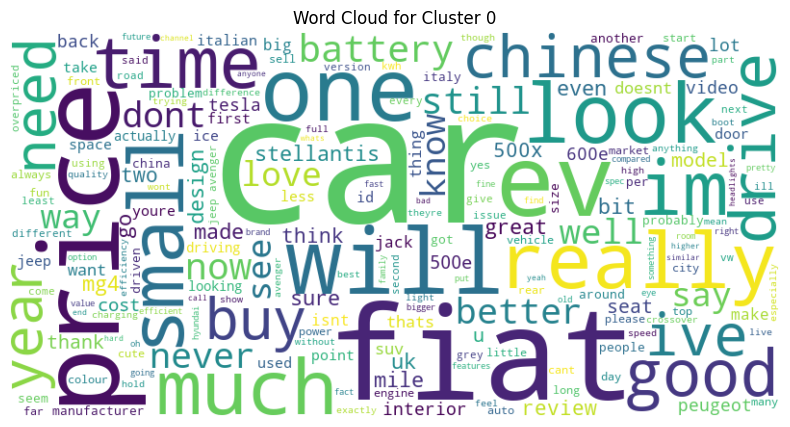

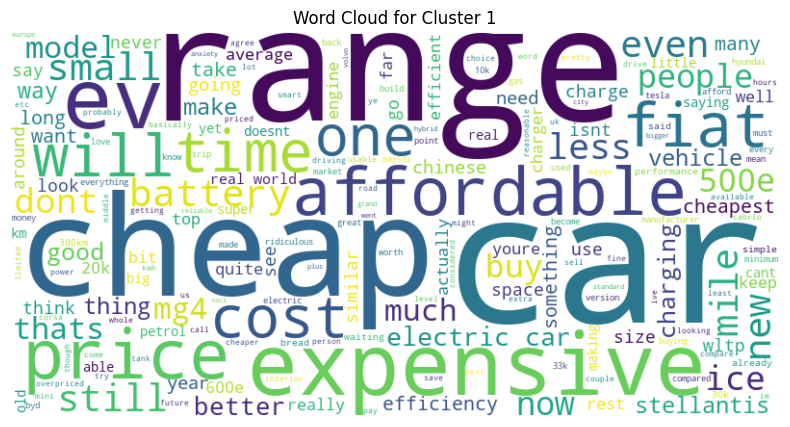

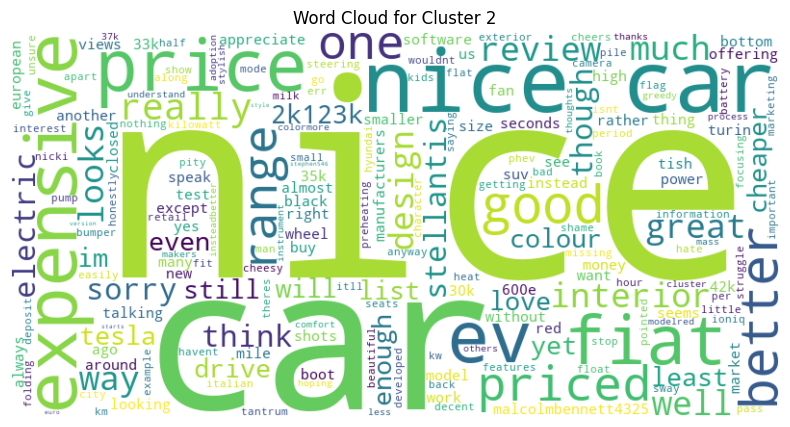

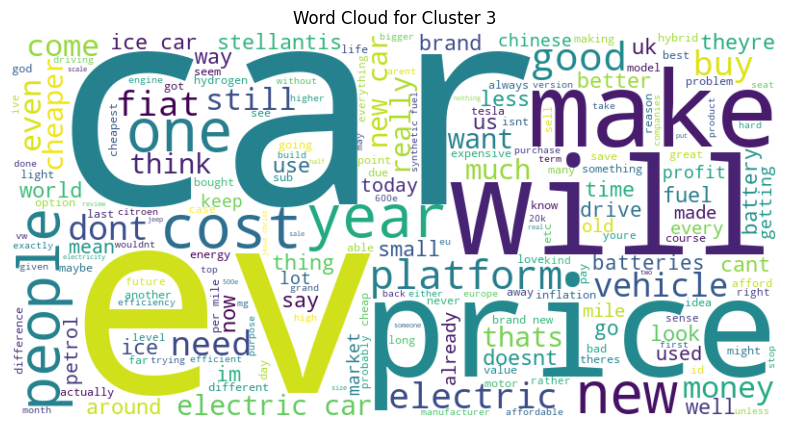

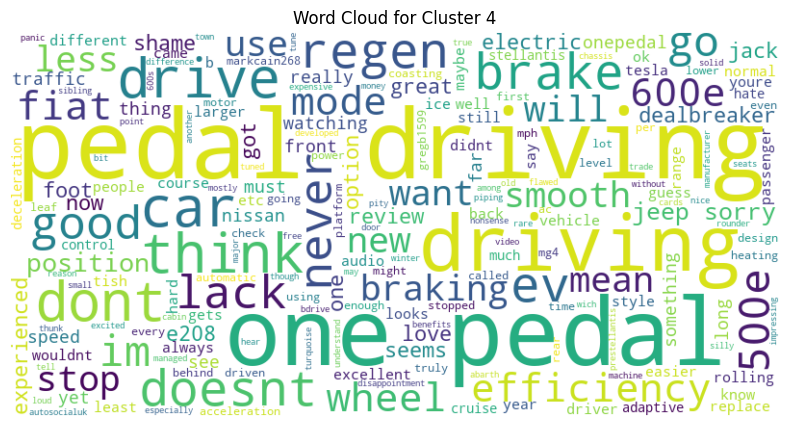

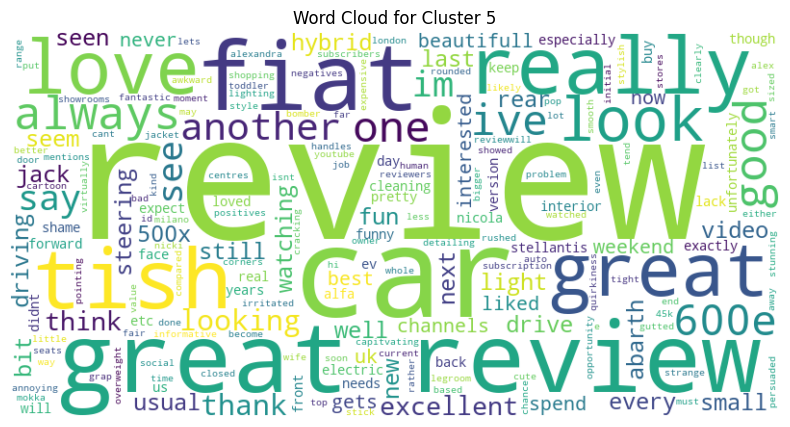

In [47]:
# Function to generate a word cloud
def generate_word_cloud(text, cluster_number):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for Cluster {cluster_number}')
    plt.axis('off')
    plt.show()

# Concatenate the text data for each cluster
cluster_texts = {}
for cluster_number in sorted(comments_600e['Cluster'].unique()):  # Sorting cluster numbers
    cluster_text = ' '.join(comments_600e[comments_600e['Cluster'] == cluster_number]['Text'])
    cluster_texts[cluster_number] = cluster_text

# Generate word clouds for each cluster
for cluster_number in sorted(cluster_texts.keys()):  # Sorting cluster numbers
    generate_word_cloud(cluster_texts[cluster_number], cluster_number)


#### Analyse Customer Journey 

In [48]:
# Preprocess the Date column
comments_600e['Date'] = pd.to_datetime(comments_600e['Date'])

# Ensure text data is clean
comments_600e['Text'] = comments_600e['Text'].astype(str)

/var/folders/81/cc9538zd0r74dhd_qp99hlbw0000gn/T/ipykernel_14970/4095276686.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Journey_Stage', y='Sentiment', data=stage_sentiment, palette='viridis')


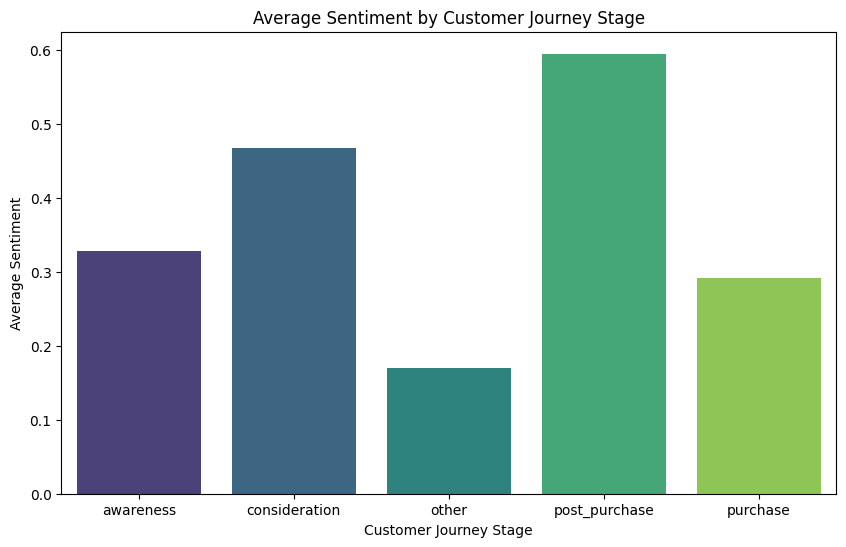

In [49]:
# Define keywords for each stage
awareness_keywords = ['thinking about buying', 'considering', 'heard about', 'looking into', 'interested in', 'thinking of', 'exploring', 'exploring options', 'curious about',
                    'potential purchase', 'contemplating', 'researching', 'initial thoughts', 'first impression', 'early stages']
consideration_keywords = ['test drive', 'review', 'comparison', 'research', 'evaluating', 'checking out', 'comparing models', 'comparing', 'reading reviews', 
                          'weighing options', 'comparison shopping', 'researching features', 'researching models', 'researching options', 'researching reviews', 'pros and cons'
                          'in-depth analysis', 'performance review', 'customer feedback']
purchase_keywords = ['just purchased', 'bought', 'ordered', 'got my', 'finally decided', 'finally bought', 'finally purchased', 'finally ordered', 'finally got', 'finally made the decision',
                     'new car', 'went ahead', 'completed purchase', 'made the purchase', 'made the decision', 'made the order', 'made the buy', 'made the choice', 'made the commitment', 'made the move',]
post_purchase_keywords = ['loving my new car', 'enjoying', 'happy with', 'satisfied with', 'impressed with', 'excited about', 'thrilled with', 'delighted with', 'pleased with', 'content with',
                          'recommend', 'would buy again']

# Function to assign journey stage
def assign_journey_stage(text):
    text = text.lower()
    for keyword in awareness_keywords:
        if keyword in text:
            return 'awareness'
    for keyword in consideration_keywords:
        if keyword in text:
            return 'consideration'
    for keyword in purchase_keywords:
        if keyword in text:
            return 'purchase'
    for keyword in post_purchase_keywords:
        if keyword in text:
            return 'post_purchase'
    return 'other'

# Apply the function to assign journey stages
comments_600e['Journey_Stage'] = comments_600e['Text'].apply(assign_journey_stage)

# Sentiment Analysis to understand sentiment at each stage of the journey
# Initialise the VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Function to calculate sentiment
def get_sentiment(text):
    return sia.polarity_scores(text)['compound']

# Apply sentiment analysis
comments_600e['Sentiment'] = comments_600e['Text'].apply(get_sentiment)

# Group by Journey_Stage and calculate mean sentiment
stage_sentiment = comments_600e.groupby('Journey_Stage')['Sentiment'].mean().reset_index()

# Plot the sentiment by journey stage
plt.figure(figsize=(10, 6))
sns.barplot(x='Journey_Stage', y='Sentiment', data=stage_sentiment, palette='viridis')
plt.title('Average Sentiment by Customer Journey Stage')
plt.xlabel('Customer Journey Stage')
plt.ylabel('Average Sentiment')
plt.show()


**Awareness Stage:**
* Average Sentiment: 0.35
* The sentiment is moderately positive.
* Customers are generally positive but cautious at this stage.
* Focus on the initial discovery of the product and brand awareness.

**Consideration Stage:**
* Average Sentiment: 0.48
* The sentiment is more positive compared to the awareness stage.
* Customers are actively evaluating the product and comparing it with alternatives.
* Positive reviews and detailed comparisons help in decision-making.

**Purchase Stage:**
* Average Sentiment: 0.33
* The sentiment is moderately positive.
* Customers are finalizing their purchase decision.
* Satisfaction with the purchase process and product features influences sentiment.

**Post-Purchase Stage:**
* Average Sentiment: 0.6
* The sentiment is highly positive.
* Customers express high satisfaction after purchasing and using the product.
* Positive experiences and usage satisfaction drive high sentiment scores.

**Other Stage:**
* Average Sentiment: 0.25
* The sentiment is lower compared to other stages.
* This category includes miscellaneous comments that do not fit into specific journey stages.
* Less focus and engagement in this stage lead to a lower sentiment score.

<Figure size 1400x800 with 0 Axes>

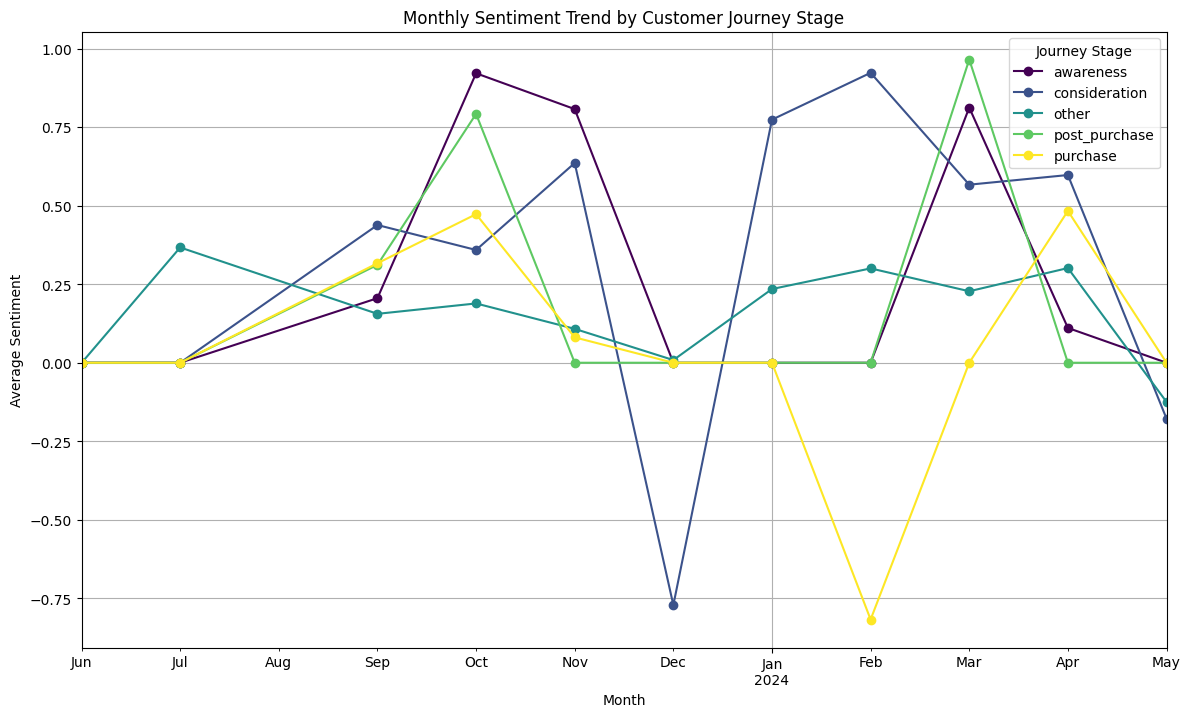

In [50]:
# Timeline analysis
# Extract month and year from the Date
comments_600e['Month'] = comments_600e['Date'].dt.to_period('M')

# Group by Month and Journey_Stage, and calculate mean sentiment
monthly_stage_sentiment = comments_600e.groupby(['Month', 'Journey_Stage'])['Sentiment'].mean().unstack().fillna(0)

# Plot the monthly sentiment trend by journey stage
plt.figure(figsize=(14, 8))
monthly_stage_sentiment.plot(kind='line', marker='o', colormap='viridis', figsize=(14, 8))
plt.title('Monthly Sentiment Trend by Customer Journey Stage')
plt.xlabel('Month')
plt.ylabel('Average Sentiment')
plt.legend(title='Journey Stage')
plt.grid(True)
plt.show()


##### Trends and Fluctuations:
**Awareness and Consideration Stages:**
* Sentiment peaks around September and dips in December.
* Seasonal trends and product launches may influence these changes.

**Purchase and Post-Purchase Stages:**
* High sentiment around January and a significant drop in February.
* Holiday season promotions and post-purchase satisfaction could drive these peaks.

**Other Stage:**
* Generally fluctuates with no significant peaks or troughs.


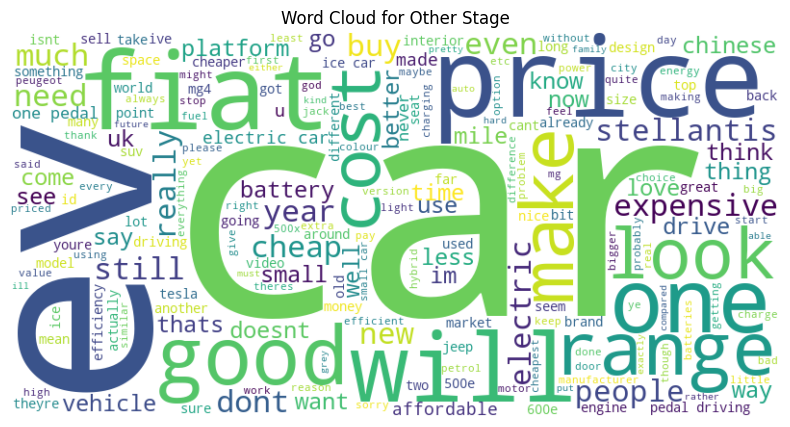

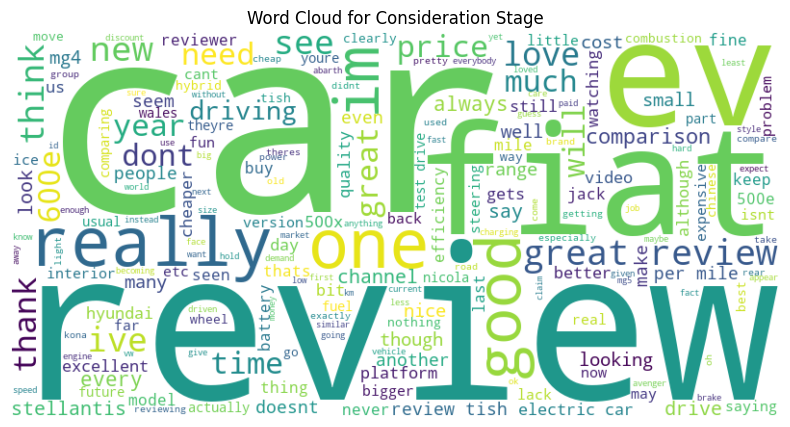

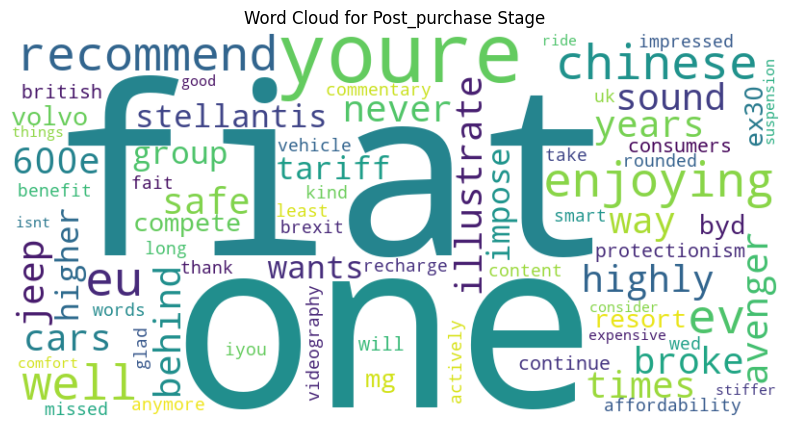

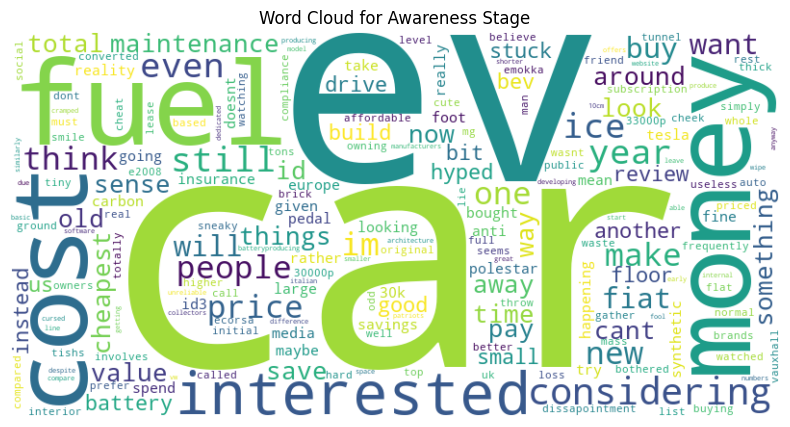

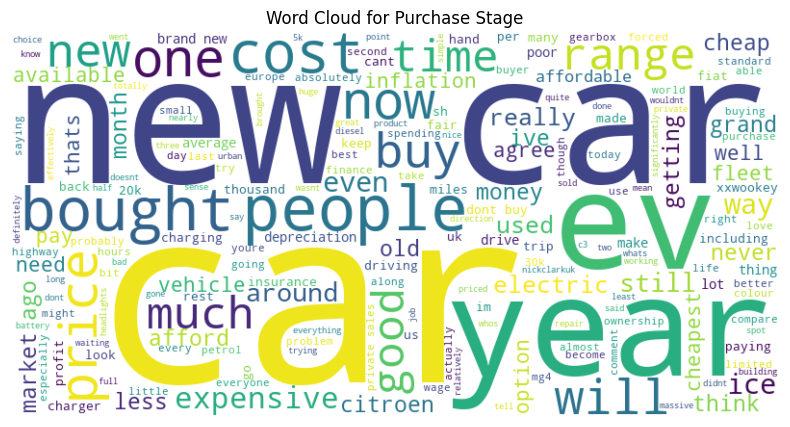

In [51]:
# Word cloud for each stage

# Function to generate word cloud
def generate_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()

# Generate word clouds for each journey stage
for stage in comments_600e['Journey_Stage'].unique():
    stage_text = ' '.join(comments_600e[comments_600e['Journey_Stage'] == stage]['Text'])
    generate_wordcloud(stage_text, f'Word Cloud for {stage.capitalize()} Stage')